## Here we show that the valid bound for VAE vector is about (-5,5)

In [6]:
# get encoder info in X
import sys
from rdkit import Chem
import torch

sys.path.append('VAE_model/cpu')
from fast_jtnn import *
VAE_path = "VAE_model/model.epoch-39"
vocab_path = "VAE_model/smi_vocab-2.txt"

vocab_list = [x.strip("\r\n ") for x in open(vocab_path)]
vocab = Vocab(vocab_list)

hidden_size = 450
latent_size = 32
depthT = 20
depthG = 3

device = torch.device("cpu")
print(torch.cuda.device_count())

VAE = JTNNVAE(vocab, hidden_size, latent_size, depthT, depthG)
VAE.load_state_dict(torch.load(VAE_path,map_location=(device)))
VAE.cpu()
VAE.eval()

[09:38:07] WARNING: not removing hydrogen atom without neighbors


0


JTNNVAE(
  (jtnn): JTNNEncoder(
    (embedding): Embedding(1223, 450)
    (outputNN): Sequential(
      (0): Linear(in_features=900, out_features=450, bias=True)
      (1): ReLU()
    )
    (GRU): GraphGRU(
      (W_z): Linear(in_features=900, out_features=450, bias=True)
      (W_r): Linear(in_features=450, out_features=450, bias=False)
      (U_r): Linear(in_features=450, out_features=450, bias=True)
      (W_h): Linear(in_features=900, out_features=450, bias=True)
    )
  )
  (decoder): JTNNDecoder(
    (embedding): Embedding(1223, 450)
    (W_z): Linear(in_features=900, out_features=450, bias=True)
    (U_r): Linear(in_features=450, out_features=450, bias=False)
    (W_r): Linear(in_features=450, out_features=450, bias=True)
    (W_h): Linear(in_features=900, out_features=450, bias=True)
    (W): Linear(in_features=466, out_features=450, bias=True)
    (U): Linear(in_features=466, out_features=450, bias=True)
    (U_i): Linear(in_features=900, out_features=450, bias=True)
    (W_o)

In [7]:
import random

def select_random_lines(file_path, num_lines_to_select):
    with open(file_path, 'r') as file:
        total_lines = sum(1 for _ in file)
    
    selected_line_numbers = set(random.sample(range(total_lines), num_lines_to_select))
    

    selected_lines = []
    with open(file_path, 'r') as file:
        for i, line in enumerate(file):
            if i in selected_line_numbers:
                selected_lines.append(line.strip())
    
    return selected_lines
smiles_csv_dir = 'VAE_model/train_data/processed_smi.txt'
num_lines_to_select = 20000
random_smiles_list = select_random_lines(smiles_csv_dir, num_lines_to_select)


In [11]:
valid_x = []
for i in range(len(random_smiles_list)):
    if i%1000 == 0:
        print("%d th SMILES finish encoding"%(i))
    try:
        latent = VAE.encode_latent_mean([random_smiles_list[i]])
        valid_x.append(latent.detach().numpy())
    except Exception as e:
        print(f"Error processing SMILES {random_smiles_list[i]}: {e}")
        continue

0 th SMILES finish encoding
Error processing SMILES CC(C)(C)N1CC2=[C-]C(=CC=C2)CN(C(C)(C)C)CC2=NC(=CC=C2)C1: '[C-]1=C2C=CC=C1CNCC1=NC(=CC=C1)CNC2'
1000 th SMILES finish encoding
2000 th SMILES finish encoding
3000 th SMILES finish encoding
4000 th SMILES finish encoding
5000 th SMILES finish encoding
6000 th SMILES finish encoding
7000 th SMILES finish encoding
8000 th SMILES finish encoding
9000 th SMILES finish encoding
10000 th SMILES finish encoding
11000 th SMILES finish encoding
12000 th SMILES finish encoding
13000 th SMILES finish encoding
14000 th SMILES finish encoding
15000 th SMILES finish encoding
16000 th SMILES finish encoding
17000 th SMILES finish encoding
18000 th SMILES finish encoding
19000 th SMILES finish encoding


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

valid_x_flattened = np.concatenate(valid_x).flatten()

mean = np.mean(valid_x_flattened).item()
std = np.std(valid_x_flattened).item()
print('mean:', mean)
print('std:', std)

mean: -0.0745263546705246
std: 1.3419417142868042


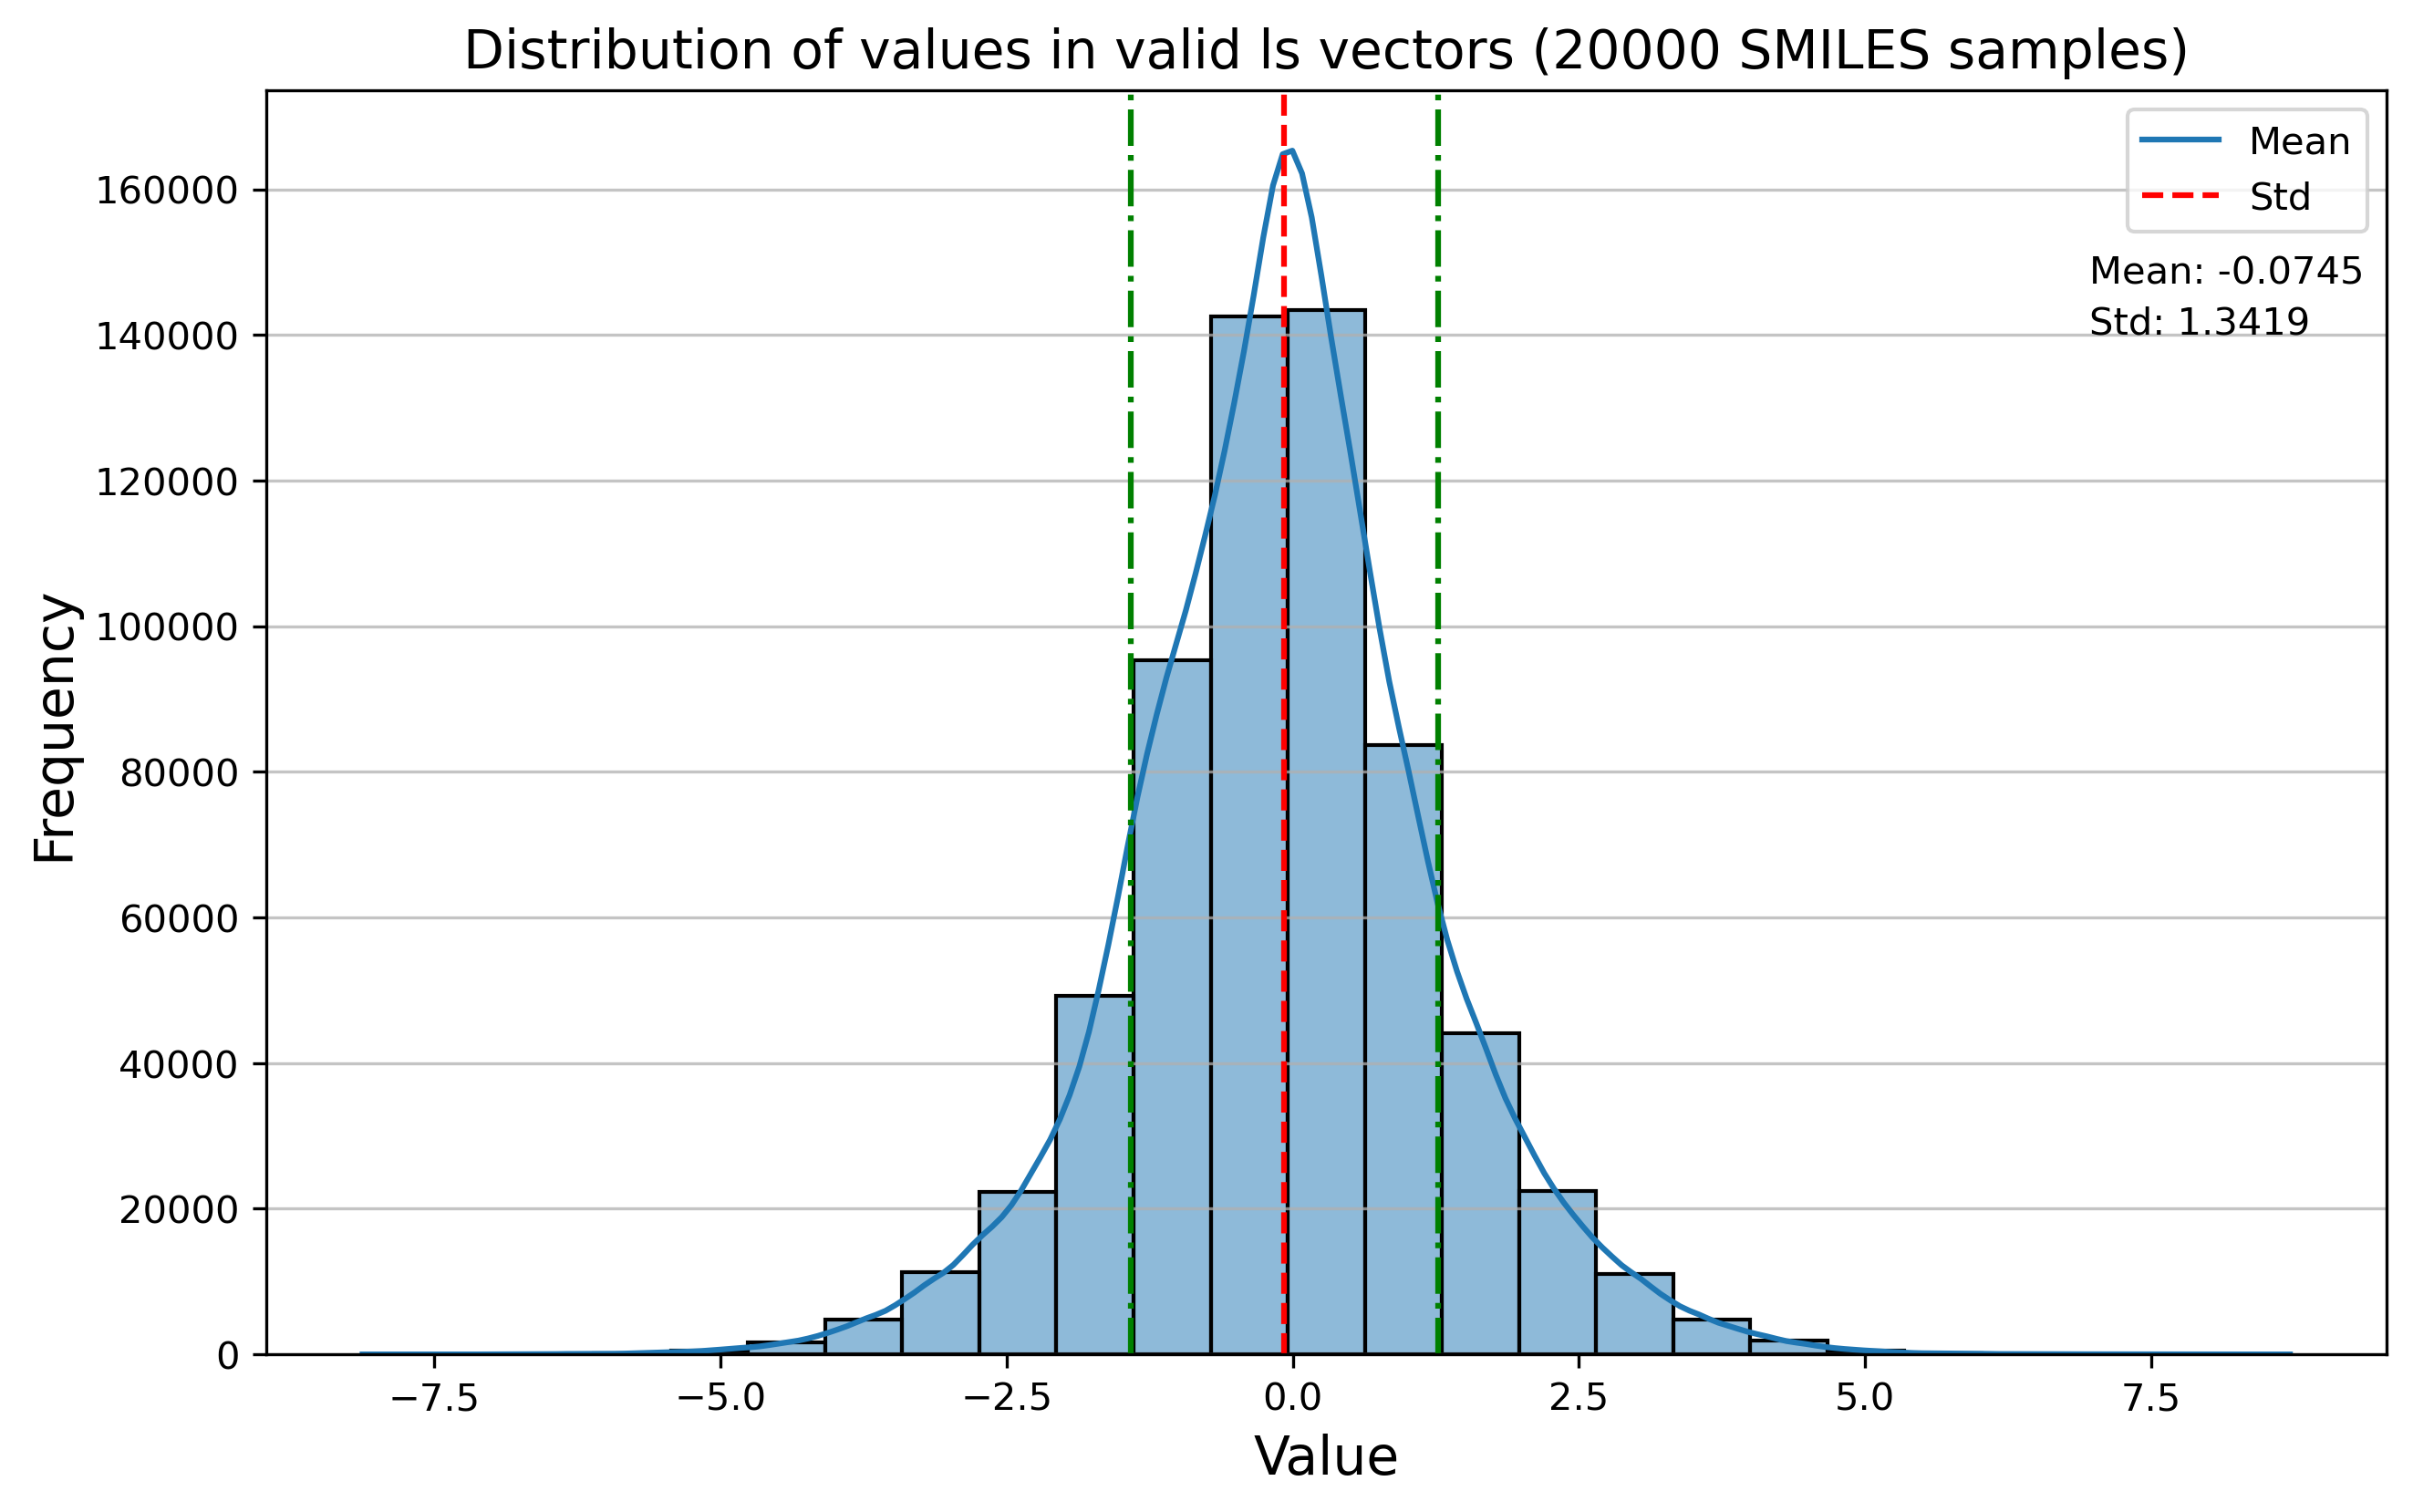

In [16]:
plt.figure(figsize=(10, 6),dpi = 300)
sns.histplot(valid_x_flattened, bins=25, kde=True)
plt.axvline(mean, color='r', linestyle='--')
plt.axvline(mean + std, color='g', linestyle='-.')
plt.axvline(mean - std, color='g', linestyle='-.')

plt.text(0.86, 0.87, f'Mean: {mean:.4f}', ha='left', va='top', transform=plt.gca().transAxes,fontsize=10)
plt.text(0.86, 0.83, f'Std: {std:.4f}', ha='left', va='top', transform=plt.gca().transAxes, fontsize=10)

plt.legend({'Mean':mean,'Std':std},fontsize=10, loc='upper right')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of values in valid ls vectors (20000 SMILES samples)', fontsize=14)
plt.show()